<a href="https://colab.research.google.com/github/blacurly/MLOps/blob/main/LakeFS_Athletes_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install lakefs-client pandas
#!pip install scikit-learn matplotlib seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import lakefs_client

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
#from lakefs_client import Configuration, ApiClient
#from lakefs_client.api import repositories_api, objects_api, commits_api, branches_api

random_state=20250701

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Quarter 4/MLOps/LakeFS/athletes_v1.csv")

#### Data Cleaning

In [ ]:
# Remove not relevant columns
data = data.dropna(subset=['region','age','weight','height','howlong','gender','eat', \
                               'train','background','experience','schedule','howlong', \
                               'deadlift','candj','snatch','backsq','experience',\
                               'background','schedule','howlong'])
data = data.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace',\
                              'filthy50','fgonebad','run400','run5k','pullups','train'])

# Remove Outliers
data = data[data['weight'] < 1500]
data = data[data['gender'] != '--']
data = data[data['age'] >= 18]
data = data[(data['height'] < 96) & (data['height'] > 48)]
data = data[(data['candj'] > 0) & (data['candj'] <= 395)]
data = data[(data['snatch'] > 0) & (data['snatch'] <= 496)]
data = data[(data['backsq'] > 0) & (data['backsq'] <= 1069)]

# Clean Survey Data
decline_dict = {'Decline to answer|': np.nan}
data = data.replace(decline_dict)
data = data.dropna(subset=['background','experience','schedule','howlong','eat'])

In [ ]:
# Add total_lift column
data['total_lift'] = data[['deadlift', 'candj', 'snatch', 'backsq']].sum(axis=1)

In [ ]:
data = data[(data['deadlift'] > 0) & (data['deadlift'] <= 1105)|((data['gender'] == 'Female') \
                 & (data['deadlift'] <= 636))]

In [ ]:
#data.to_csv("/content/drive/MyDrive/Quarter 4/MLOps/athletes_v2.csv", index=False)

#### Exploratory Data Analysis (EDA)

In [ ]:
data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 30029 entries, 21 to 422961
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      30029 non-null  object 
 1   gender      30029 non-null  object 
 2   age         30029 non-null  float64
 3   height      30029 non-null  float64
 4   weight      30029 non-null  float64
 5   candj       30029 non-null  float64
 6   snatch      30029 non-null  float64
 7   deadlift    30029 non-null  float64
 8   backsq      30029 non-null  float64
 9   eat         30029 non-null  object 
 10  background  30029 non-null  object 
 11  experience  30029 non-null  object 
 12  schedule    30029 non-null  object 
 13  howlong     30029 non-null  object 
 14  total_lift  30029 non-null  float64
dtypes: float64(8), object(7)
memory usage: 3.7+ MB


,region,gender,age,height,weight,candj,snatch,deadlift,backsq,eat,background,experience,schedule,howlong,total_lift
21,Southern California,Male,30.0,71.0,200.0,235.0,175.0,385.0,315.0,I eat whatever is convenient|,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 1x a week|I ty...,1-2 years|,1110.0
22,Africa,Male,28.0,70.0,176.0,187.0,134.0,335.0,254.0,I eat 1-3 full cheat meals per week|,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 1x a week|,2-4 years|,910.0
27,North East,Male,35.0,68.0,225.0,285.0,205.0,440.0,405.0,I eat quality foods but don't measure the amount|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I typically rest 4 or more days per month|,2-4 years|,1335.0
50,North Central,Male,36.0,71.0,199.0,267.0,212.0,485.0,390.0,I eat quality foods but don't measure the amount|,I played youth or high school level sports|I p...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 3+ times a wee...,1-2 years|,1354.0
60,North East,Male,36.0,64.0,155.0,245.0,180.0,415.0,385.0,I eat strict Paleo|,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 2x a week|I st...,4+ years|,1225.0


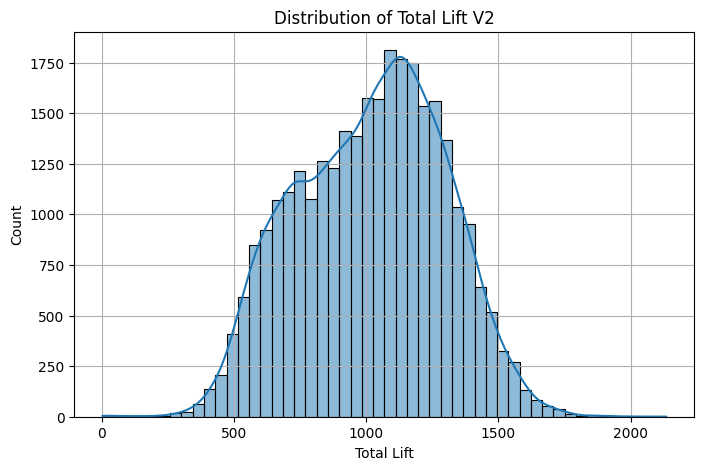

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data['total_lift'], bins=50, kde=True)
plt.title("Distribution of Total Lift V2")
plt.xlabel("Total Lift")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [ ]:
#correlation = athletes_v1.corr(numeric_only=True)
#sns.heatmap(correlation[['total_lift']].sort_values(by='total_lift', ascending=False), annot=True)

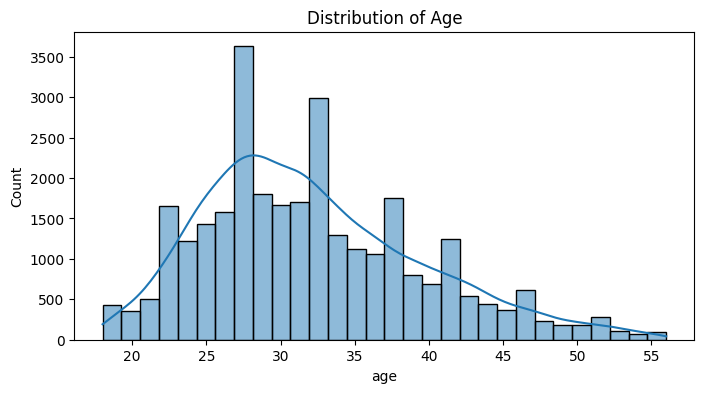

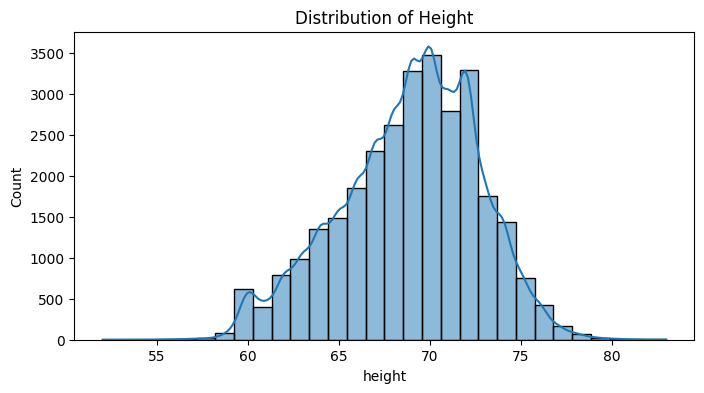

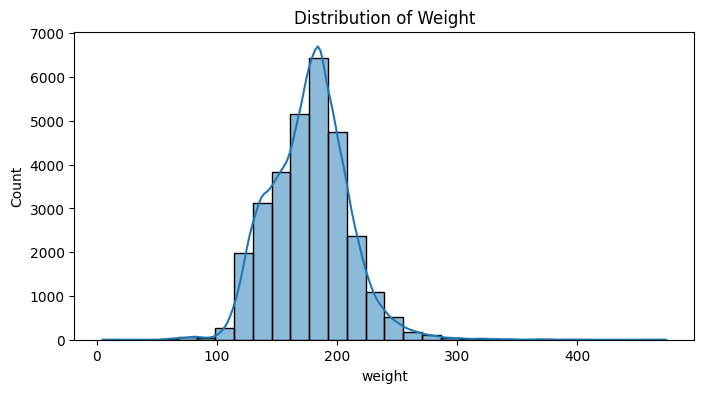

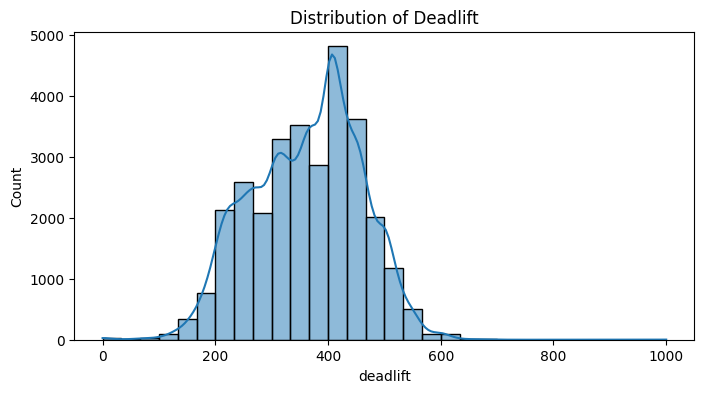

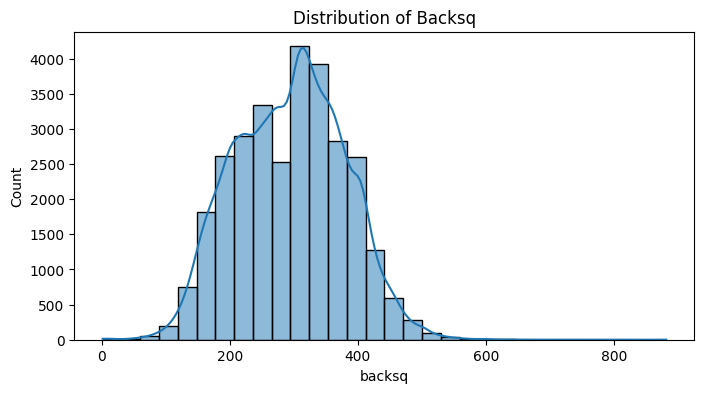

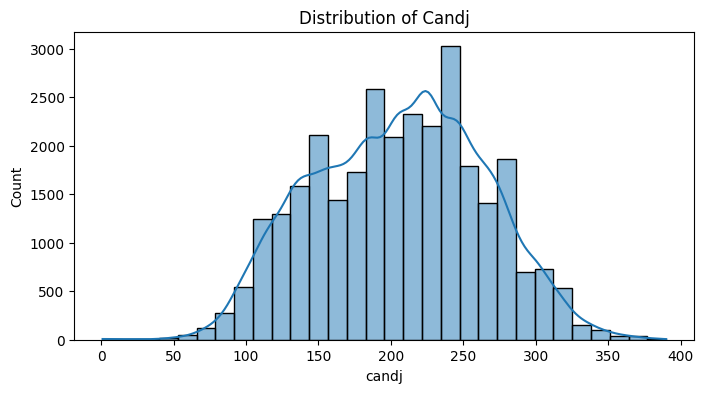

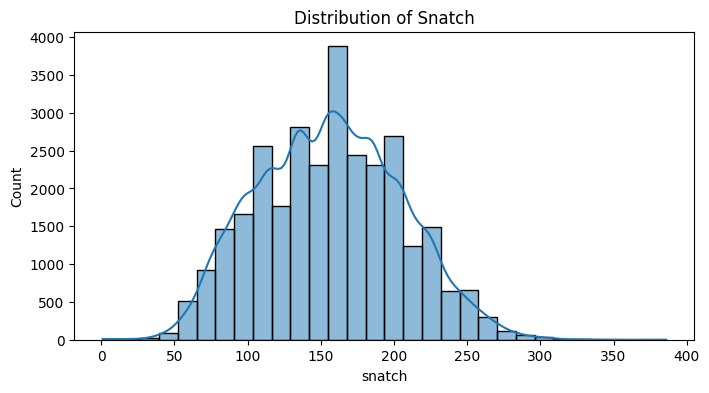

In [ ]:
metrics = ['age','height','weight', 'deadlift', 'backsq', 'candj', 'snatch']
for metric in metrics:
    plt.figure(figsize=(8,4))
    sns.histplot(data[metric], bins=30, kde=True)
    plt.title(f"Distribution of {metric.capitalize()}")
    plt.show()

In [ ]:
# Show unique values for object-type columns
categorical_cols = data.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f"{col} — {data[col].nunique()} unique values")
    print(data[col].value_counts(dropna=False).head(), "\n")

region — 17 unique values
region
South East       2988
North East       2913
North Central    2767
Mid Atlantic     2552
Europe           2484
Name: count, dtype: int64 

gender — 2 unique values
gender
Male      21823
Female     8206
Name: count, dtype: int64 

eat — 40 unique values
eat
I eat quality foods but don't measure the amount|                                        13987
I eat quality foods but don't measure the amount|I eat 1-3 full cheat meals per week|     4639
I eat whatever is convenient|                                                             2845
I eat quality foods but don't measure the amount|I eat whatever is convenient|            1445
I weigh and measure my food|                                                              1388
Name: count, dtype: int64 

background — 35 unique values
background
I played youth or high school level sports|                                         10750
I played youth or high school level sports|I regularly play recreational spo

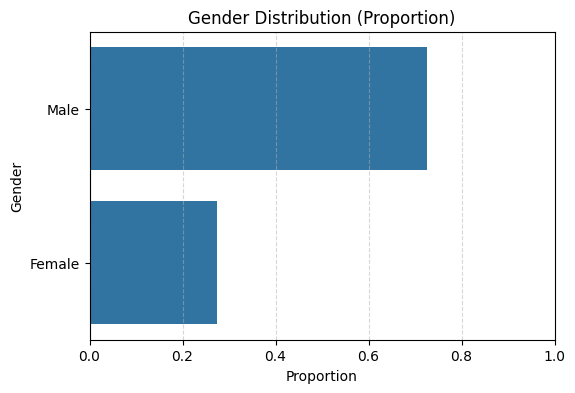

In [ ]:
# Gender Proportion
gender_counts = data['gender'].value_counts(normalize=True)
plt.figure(figsize=(6,4))
sns.barplot(x=gender_counts.values, y=gender_counts.index)
plt.title("Gender Distribution (Proportion)")
plt.xlabel("Proportion")
plt.ylabel("Gender")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

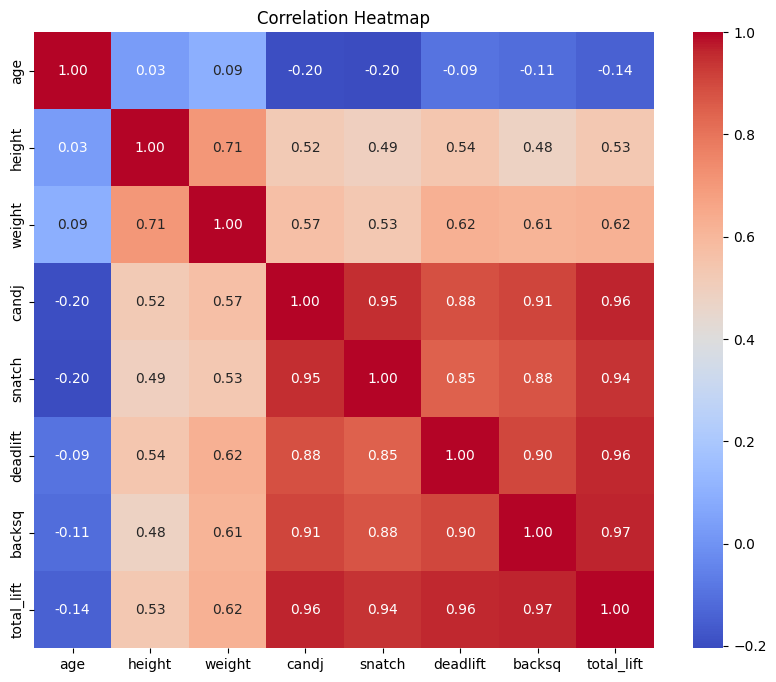

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
features = ['age','height','weight', 'deadlift', 'backsq', 'candj', 'snatch']
target = 'total_lift'

# Split
X = data[features]
y = data[target]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (24023, 7), Test shape: (6006, 7)


#### Mean Regressor

In [ ]:
mean_regressor = DummyRegressor(strategy="mean")
mean_regressor.fit(X_train, y_train)
mean_pred = mean_regressor.predict(X_test)

#### Random Forest

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

#### XGBoost

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, random_state=random_state)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [ ]:
def evaluate_model(name, y_true, y_pred):
    print(f"{name} Performance:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"MAE : {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"R²  : {r2_score(y_true, y_pred):.3f}")
    print("-" * 30)

evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("XGBoost", y_test, xgb_pred)
evaluate_model("Mean", y_test, mean_pred)

Random Forest Performance:
RMSE: 10.77
MAE : 4.40
R²  : 0.998
------------------------------
XGBoost Performance:
RMSE: 9.03
MAE : 5.49
R²  : 0.999
------------------------------
Mean Performance:
RMSE: 277.07
MAE : 230.48
R²  : -0.000
------------------------------


In [ ]:
sample_test_data = X_test.sample(5, random_state=random_state)
sample_pred_rf = rf_model.predict(sample_test_data)
sample_pred_xgb = xgb_model.predict(sample_test_data)
sample_pred_mean = mean_regressor.predict(sample_test_data)

sample_results = sample_test_data.copy()
sample_results['Actual Total Lift'] = y_test.loc[sample_test_data.index]
sample_results['RF Predicted Total Lift'] = sample_pred_rf
sample_results['XGB Predicted Total Lift'] = sample_pred_xgb
sample_results['Mean Predicted Total Lift'] = sample_pred_mean

print("\nPredictions on Sample Test Data:")
sample_results


Predictions on Sample Test Data:


,age,height,weight,deadlift,backsq,candj,snatch,Actual Total Lift,RF Predicted Total Lift,XGB Predicted Total Lift,Mean Predicted Total Lift
78376,28.0,71.0,163.0,375.0,335.0,245.0,225.0,1180.0,1160.23,1168.988037,1017.102069
87699,24.0,64.0,143.0,419.0,331.0,231.0,183.0,1164.0,1164.02,1162.873413,1017.102069
23210,30.0,73.0,185.0,405.0,335.0,265.0,215.0,1220.0,1226.73,1222.989624,1017.102069
124342,34.0,70.0,177.0,331.0,309.0,209.0,143.0,992.0,995.10,1002.665161,1017.102069
67264,28.0,72.0,180.0,300.0,215.0,185.0,125.0,825.0,829.45,825.954346,1017.102069


In [ ]:
pip install opacus